In [5]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 12.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import datasets
import transformers
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

import tensorflow as tf
from tensorflow import keras
from keras import layers as L
from keras import models as M
from keras import losses as LL

from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay

import torch

In [26]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{DEVICE = }")

DEVICE = device(type='cuda')


# Hello world

## Sentiment analysis

In [ ]:
classifier = pipeline("text-classification")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
classifier("this movie was bad")

[{'label': 'NEGATIVE', 'score': 0.9997972846031189}]

In [ ]:
classifier("It wasn't as good ad the previous")

[{'label': 'NEGATIVE', 'score': 0.9997695088386536}]

In [ ]:
classifier("The enjoyment I got from the evening was just that from the 1lb popcon I got at the theater")

[{'label': 'POSITIVE', 'score': 0.9938271641731262}]

## NER

In [ ]:
classifier = pipeline("ner", aggregation_strategy="simple")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
text = """
Trade ministers are not known for histrionics. 
Yet South Korea’s, Ahn Duk-geun, is alarmed. 
The world is on the verge of opening Pandora’s box, he warned last month. 
If the European Union follows through on threats 
to mimic America’s protectionist industrial policies, 
“Japan, Korea, China, every country will engage in this very difficult race 
to ignore global trading rules.”
"""
output = classifier(text)
pd.DataFrame(output)

,entity_group,score,word,start,end
0,LOC,0.999712,South Korea,53,64
1,PER,0.966197,Ahn Duk,68,75
2,PER,0.608237,geun,76,80
3,ORG,0.999320,European Union,177,191
4,LOC,0.999527,America,229,236
5,LOC,0.999736,Japan,276,281
6,LOC,0.999751,Korea,283,288
7,LOC,0.999734,China,290,295


# Simple fine-tuning

In [7]:
ds = datasets.load_dataset("SetFit/emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [9]:
ds["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

In [10]:
ds.set_format("pandas")
df = ds["train"][:]
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [67]:
labels = df[["label", "label_text"]].drop_duplicates().set_index("label").sort_index()

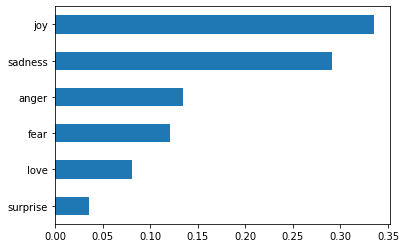

In [11]:
df["label_text"].value_counts(normalize=True, ascending=True).plot.barh()
plt.show()

In [12]:
ds.reset_format()

In [13]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
def tokenize(x):
    return tokenizer(x["text"], padding=True, truncation=True)

tokenize(ds["train"][:5])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [15]:
ds_tkn = ds.map(
    function=tokenize,
    batched=True,
    batch_size=64,
)

  0%|          | 0/250 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

In [27]:
num_labels = 6
model = (
    AutoModelForSequenceClassification
    .from_pretrained(model_name, num_labels=num_labels)
    .to(DEVICE)
)

In [28]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [29]:
batch_size = 64
logging_steps = len(ds_tkn["train"]) // batch_size

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-emotion",
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
)

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ds_tkn["train"],
    eval_dataset=ds_tkn["validation"],
    tokenizer=tokenizer
)
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.840800,0.330607,0.897500,0.894542
2,0.250200,0.220438,0.922000,0.921773


TrainOutput(global_step=500, training_loss=0.54553515625, metrics={'train_runtime': 207.0649, 'train_samples_per_second': 154.541, 'train_steps_per_second': 2.415, 'total_flos': 631782088722432.0, 'train_loss': 0.54553515625, 'epoch': 2.0})

In [32]:
preds_test = trainer.predict(ds_tkn["test"])

In [39]:
preds_test.metrics

{'test_loss': 0.21858936548233032,
 'test_accuracy': 0.916,
 'test_f1': 0.9153941659984692,
 'test_runtime': 3.7187,
 'test_samples_per_second': 537.825,
 'test_steps_per_second': 8.605}

In [53]:
preds_test.label_ids.shape

(2000,)

In [54]:
np.argmax(preds_test.predictions, -1).shape

(2000,)

In [75]:
labels.values.squeeze().tolist()

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

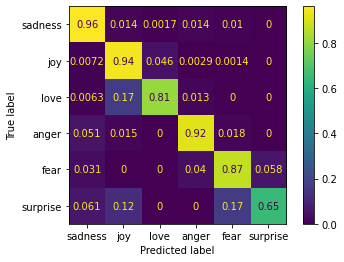

In [78]:
ConfusionMatrixDisplay.from_predictions(
    y_true=preds_test.label_ids,
    y_pred=np.argmax(preds_test.predictions, -1),
    normalize="true",
    display_labels=labels.values.squeeze().tolist(),
)

In [79]:
# Random tests

In [ ]:
transformer = TFAutoModel.from_pretrained(model_name)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
x = tokenizer(ds_tkn["train"][0]["text"], return_tensors="tf")
print(f"{x.keys()=}")

x["input_ids"].shape

out = transformer.predict(x=(x["input_ids"], x["attention_mask"]))
# alternatives
# out = transformer.predict(x={"input_ids": x["input_ids"], "attention_mask":x["attention_mask"]})
# transformer(x)

print(f"{out.keys() = }")
print(f"{out['last_hidden_state'][:, 0, :].shape = }")

x.keys()=dict_keys(['input_ids', 'attention_mask'])
1/1 [==============================] - 1s 1s/step
out.keys() = odict_keys(['last_hidden_state'])
out['last_hidden_state'][:, 0, :].shape = (1, 768)


In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
input_ids = L.Input(shape=(None, ), dtype=tf.int32, name="input_ids")
attention_mask = L.Input(shape=(None, ), dtype=tf.int32, name="attention_mask")
embeddings = transformer(input_ids=input_ids, attention_mask=attention_mask)
x = L.Dense(units=64, activation="relu")(embeddings["last_hidden_state"][0])
x = L.Dense(units=1, activation="softmax")(x)
model = M.Model(inputs=[input_ids, attention_mask], outputs=x)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, None, 768),                                                  
                                 hidden_states=None                                        

In [ ]:
ds_tkn.reset_format()

In [ ]:
ds_tkn_y = ds_tkn.map(lambda x: {"label": x["label"]}, batch_size=64, batched=True)
ds_tkn_x = ds_tkn.map(lambda x: {"input_ids": x["input_ids"], "attention_mask": x["attention_mask"]}, batch_size=64, batched=True)

  0%|          | 0/250 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/250 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

In [ ]:
ds_tkn.set_format("tf")

In [ ]:
ds_tkn

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
ds_tkn_train_x = ds_tkn.remove_columns(["text", "label", "label_text"])["train"][:]
ds_tkn_train_y = ds_tkn.remove_columns(["text", "input_ids", "attention_mask", "label_text"])["train"][:]

ds_tkn_val_x = ds_tkn.remove_columns(["text", "label", "label_text"])["validation"][:]
ds_tkn_val_y = ds_tkn.remove_columns(["text", "input_ids", "attention_mask", "label_text"])["validation"][:]

ds_tkn_test_x = ds_tkn.remove_columns(["text", "label", "label_text"])["test"][:]
ds_tkn_test_y = ds_tkn.remove_columns(["text", "input_ids", "attention_mask", "label_text"])["test"][:]

In [ ]:
tf_ds_train = tf.data.Dataset.from_tensor_slices((ds_tkn_train_x, ds_tkn_train_y,))
tf_ds_valid = tf.data.Dataset.from_tensor_slices((ds_tkn_val_x, ds_tkn_val_y,))
tf_ds_test = tf.data.Dataset.from_tensor_slices((ds_tkn_test_x, ds_tkn_test_y,))

In [ ]:
BATCH_SIZE = 64
BUFFER = 1000

tf_ds_train_prep = tf_ds_train.batch(BATCH_SIZE).shuffle(buffer_size=BUFFER)
tf_ds_valid_prep = tf_ds_valid.batch(BATCH_SIZE)
tf_ds_test_prep = tf_ds_test.batch(BATCH_SIZE)

In [ ]:
model.predict(tf_ds_test_prep)

ValueError: in user code:

    File "/home/calcifer/git/marco/learn-deep-learning/.env/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/calcifer/git/marco/learn-deep-learning/.env/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/calcifer/git/marco/learn-deep-learning/.env/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/calcifer/git/marco/learn-deep-learning/.env/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/calcifer/git/marco/learn-deep-learning/.env/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filek5j84r24.py", line 33, in tf__run_call_with_unpacked_inputs
        unpacked_inputs = ag__.converted_call(ag__.ld(input_processing), (ag__.ld(func), ag__.ld(config)), dict(**ag__.ld(fn_args_and_kwargs)), fscope)
    File "/tmp/__autograph_generated_filezvqrc3gs.py", line 138, in tf__input_processing
        ag__.for_stmt(ag__.converted_call(ag__.ld(kwargs).items, (), None, fscope), None, loop_body, get_state_7, set_state_7, (), {'iterate_names': '(k, v)'})
    File "/tmp/__autograph_generated_filezvqrc3gs.py", line 135, in loop_body
        ag__.if_stmt(ag__.or_(lambda : ag__.converted_call(ag__.ld(isinstance), (ag__.ld(v), ag__.ld(allowed_types)), None, fscope), lambda : ag__.ld(v) is None), if_body_6, else_body_6, get_state_6, set_state_6, ('output[k]',), 1)
    File "/tmp/__autograph_generated_filezvqrc3gs.py", line 134, in else_body_6
        raise ag__.converted_call(ag__.ld(ValueError), (f'Data of type {ag__.converted_call(ag__.ld(type), (ag__.ld(v),), None, fscope)} is not allowed only {ag__.ld(allowed_types)} is accepted for {ag__.ld(k)}.',), None, fscope)

    ValueError: Exception encountered when calling layer 'tf_distil_bert_model_1' (type TFDistilBertModel).
    
    in user code:
    
        File "/home/calcifer/git/marco/learn-deep-learning/.env/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 558, in run_call_with_unpacked_inputs  *
            unpacked_inputs = input_processing(func, config, **fn_args_and_kwargs)
        File "/home/calcifer/git/marco/learn-deep-learning/.env/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 508, in input_processing  *
            raise ValueError(f"Data of type {type(v)} is not allowed only {allowed_types} is accepted for {k}.")
    
        ValueError: Data of type <class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'> is not allowed only (<class 'tensorflow.python.framework.ops.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>, <class 'keras.engine.keras_tensor.KerasTensor'>) is accepted for attention_mask.
    
    
    Call arguments received by layer 'tf_distil_bert_model_1' (type TFDistilBertModel):
      • self=tf.RaggedTensor(values=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:1", shape=(None,), dtype=int32), row_splits=Tensor("RaggedFromVariant_1/RaggedTensorFromVariant:0", shape=(None,), dtype=int32))
      • input_ids=None
      • attention_mask=tf.RaggedTensor(values=Tensor("model_10/Cast:0", shape=(None,), dtype=int32), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(None,), dtype=int32))
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • training=False


In [ ]:
model.compile(
    optimizer="adam",
    loss=LL.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [ ]:
model.train(
    tf_ds_train
    
    